# Analisi Variabili Testuali - Questionario sul Medioevo

Questo notebook analizza le variabili **categoriche non mappabili** (risposte testuali):
- **Date di inizio e fine medioevo** → Clustering
- **Motivazioni delle date** → Analisi tematica
- **Commento aperto finale** → NLP (Natural Language Processing)
- **Termini associati al medioevo** → Frequenze e pattern

**Correlazioni** con variabili demografiche (età, istruzione, opinione)

## 1. Caricamento Dati e Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Impostazioni grafiche
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Caricamento dati
df = pd.read_csv('risposte.csv')

# Rinomina colonne principali (stesso mapping del notebook precedente)
column_mapping = {
    'Informazioni cronologiche': 'timestamp',
    'Sesso': 'sesso',
    'Quanti anni compi nell\'anno corrente 2025?': 'eta',
    'Qual è l\'ultimo titolo di studi che hai conseguito?': 'titolo_studio',
    'Hai mai frequentato un corso universitario o accademico che trattava anche solo in parte di storia medievale?': 'corso_medievale',
    'Regione': 'regione',
    'Provincia (sigla)': 'provincia',
    'Con quali modalità ti informi sul medioevo?': 'modalita_info',
    'Qual è la tua opinione generale sul medioevo? [Medioevo]': 'opinione_medioevo',
    'Indica la data o il secolo in cui secondo te inizia il medioevo': 'data_inizio',
    'Perché? Inizio': 'perche_inizio',
    'Indica la data o il secolo in cui secondo te finisce il medioevo': 'data_fine',
    'Perché?  Fine': 'perche_fine',
    'Quali di questi termini associ più fortemente con la tua idea di medioevo? (Max 5 risposte)': 'termini_associati',
    'Se volessi aggiungere un tuo commento facoltativo su cosa pensi sia il medioevo': 'commento_aperto',
    ' [Feudalesimo]': 'feudalesimo',
    '[Superstizione]': 'superstizione',
    '[Germanico]': 'germanico',
    '[Eroico]': 'eroico',
    '[Comunale]': 'comunale',
    '[Sperimentazione]': 'sperimentazione',
    '[Cristiano]': 'cristiano',
    '[Oscurantismo]': 'oscurantismo',
    '[Rinascita]': 'rinascita',
    '[Decadenza]': 'decadenza'
}

for old_name, new_name in column_mapping.items():
    if old_name in df.columns:
        df = df.rename(columns={old_name: new_name})

df.columns = df.columns.str.strip()

print(f"✅ Dataset caricato: {len(df)} risposte")
print(f"\n📝 Variabili testuali da analizzare:")
text_cols = ['data_inizio', 'perche_inizio', 'data_fine', 'perche_fine', 'termini_associati', 'commento_aperto']
for col in text_cols:
    if col in df.columns:
        non_null = df[col].notna().sum()
        print(f"   • {col}: {non_null} risposte ({non_null/len(df)*100:.1f}%)")

✅ Dataset caricato: 343 risposte

📝 Variabili testuali da analizzare:
   • data_inizio: 343 risposte (100.0%)
   • perche_inizio: 275 risposte (80.2%)
   • data_fine: 343 risposte (100.0%)
   • perche_fine: 282 risposte (82.2%)
   • termini_associati: 343 risposte (100.0%)
   • commento_aperto: 154 risposte (44.9%)


In [2]:
# Applica le conversioni numeriche (stesso del notebook precedente)
# per poter correlare con le variabili demografiche

# Età numerica
eta_map = {
    '18-19': 18.5, '20-29': 24.5, '30-39': 34.5, '40-49': 44.5,
    '50-59': 54.5, '60-69': 64.5, '70-79': 75, '70+': 75, '80+': 85
}
df['eta_num'] = df['eta'].map(eta_map)

# Titolo di studio ordinale
titolo_map = {
    'Licenza elementare': 1, 'Licenza media': 2,
    'Diploma di istruzione professionale': 3, 'Diploma di istruzione tecnica': 4,
    'Diploma di istruzione liceale': 5, 'Laurea triennale': 6,
    'Laurea magistrale': 7, 'Dottorato': 8
}
df['titolo_studio_num'] = df['titolo_studio'].map(titolo_map)

# Opinione medioevo numerica
opinione_map = {
    'Assolutamente negativa': 1, 'Parzialmente negativa': 2,
    'Neutrale': 3, 'Parzialmente positiva': 4, 'Assolutamente positiva': 5
}
df['opinione_num'] = df['opinione_medioevo'].map(opinione_map)

# Corso medievale
df['corso_num'] = df['corso_medievale'].map({'Sì': 1, 'No': 0})

print("✅ Variabili numeriche create per correlazioni:")
print(f"   • eta_num: media {df['eta_num'].mean():.1f}")
print(f"   • titolo_studio_num: media {df['titolo_studio_num'].mean():.1f}")
print(f"   • opinione_num: media {df['opinione_num'].mean():.2f}")
print(f"   • corso_num: {df['corso_num'].sum()} hanno frequentato corsi")

✅ Variabili numeriche create per correlazioni:
   • eta_num: media 38.9
   • titolo_studio_num: media 5.2
   • opinione_num: media 2.98
   • corso_num: 81 hanno frequentato corsi


## 2. Analisi e Clustering delle Date (Inizio/Fine Medioevo)

In [3]:
def estrai_anno(testo):
    """
    Estrae un anno numerico da una risposta testuale.
    Gestisce formati come: '476', '476 d.C.', 'V secolo', '1492', etc.
    """
    if pd.isna(testo):
        return None
    
    testo = str(testo).lower().strip()
    
    # Mapping secoli romani -> anno medio
    secoli_romani = {
        'i': 50, 'ii': 150, 'iii': 250, 'iv': 350, 'v': 450,
        'vi': 550, 'vii': 650, 'viii': 750, 'ix': 850, 'x': 950,
        'xi': 1050, 'xii': 1150, 'xiii': 1250, 'xiv': 1350, 'xv': 1450,
        'xvi': 1550, 'xvii': 1650, 'xviii': 1750
    }
    
    # Pattern per secoli romani (es. "V secolo", "XV sec")
    match_romano = re.search(r'\b(i{1,3}|iv|vi{0,3}|ix|xi{0,3}|xiv|xv|xvi{0,3})\b\s*(secolo|sec\.?|°)', testo)
    if match_romano:
        secolo = match_romano.group(1)
        if secolo in secoli_romani:
            return secoli_romani[secolo]
    
    # Pattern per anni espliciti (es. "476", "1492", "476 d.c.")
    match_anno = re.search(r'\b(\d{3,4})\b', testo)
    if match_anno:
        anno = int(match_anno.group(1))
        # Correggi anni < 100 che probabilmente sono secoli
        if anno < 100:
            return anno * 100 + 50
        return anno
    
    # Pattern per secoli con numero (es. "5° secolo", "XV secolo")
    match_num_sec = re.search(r'(\d{1,2})\s*(°|º)?\s*(secolo|sec)', testo)
    if match_num_sec:
        secolo = int(match_num_sec.group(1))
        return secolo * 100 - 50
    
    # Pattern "dopo il" con numero
    match_dopo = re.search(r'dopo\s+(?:il\s+)?(\d{3,4})', testo)
    if match_dopo:
        return int(match_dopo.group(1))
    
    return None

# Estrai anni dalle risposte
df['anno_inizio'] = df['data_inizio'].apply(estrai_anno)
df['anno_fine'] = df['data_fine'].apply(estrai_anno)

# Statistiche
print("=" * 60)
print("📅 ESTRAZIONE DATE")
print("=" * 60)

for col, label in [('anno_inizio', 'Inizio Medioevo'), ('anno_fine', 'Fine Medioevo')]:
    valid = df[col].dropna()
    print(f"\n{label}:")
    print(f"   Risposte valide estratte: {len(valid)} ({len(valid)/len(df)*100:.1f}%)")
    if len(valid) > 0:
        print(f"   Media: {valid.mean():.0f}")
        print(f"   Mediana: {valid.median():.0f}")
        print(f"   Min: {valid.min():.0f}, Max: {valid.max():.0f}")

📅 ESTRAZIONE DATE

Inizio Medioevo:
   Risposte valide estratte: 309 (90.1%)
   Media: 608
   Mediana: 476
   Min: 50, Max: 1800

Fine Medioevo:
   Risposte valide estratte: 316 (92.1%)
   Media: 1462
   Mediana: 1492
   Min: 500, Max: 1942


In [4]:
# Clustering manuale basato su periodi storici significativi

def cluster_data_inizio(anno):
    """Classifica la data di inizio in cluster storici"""
    if pd.isna(anno):
        return 'Non specificato'
    if anno < 400:
        return 'Pre-476 (ante caduta Roma)'
    elif anno <= 500:
        return '476-500 (Caduta Impero Romano Occ.)'
    elif anno <= 600:
        return '500-600 (Alto Medioevo)'
    elif anno <= 800:
        return '600-800 (Periodo pre-carolingio)'
    elif anno <= 1000:
        return '800-1000 (Impero Carolingio)'
    else:
        return '1000+ (Basso Medioevo)'

def cluster_data_fine(anno):
    """Classifica la data di fine in cluster storici"""
    if pd.isna(anno):
        return 'Non specificato'
    if anno < 1400:
        return 'Pre-1400 (Fine anticipata)'
    elif anno <= 1453:
        return '1400-1453 (Caduta Costantinopoli)'
    elif anno <= 1492:
        return '1454-1492 (Scoperta America)'
    elif anno <= 1517:
        return '1493-1517 (Riforma protestante)'
    else:
        return '1518+ (Fine posticipata)'

df['cluster_inizio'] = df['anno_inizio'].apply(cluster_data_inizio)
df['cluster_fine'] = df['anno_fine'].apply(cluster_data_fine)

# Distribuzione dei cluster
print("=" * 60)
print("📊 CLUSTERING DATE")
print("=" * 60)

print("\n🔹 CLUSTER DATA INIZIO MEDIOEVO:")
cluster_inizio_counts = df['cluster_inizio'].value_counts()
for cluster, count in cluster_inizio_counts.items():
    print(f"   {cluster}: {count} ({count/len(df)*100:.1f}%)")

print("\n🔹 CLUSTER DATA FINE MEDIOEVO:")
cluster_fine_counts = df['cluster_fine'].value_counts()
for cluster, count in cluster_fine_counts.items():
    print(f"   {cluster}: {count} ({count/len(df)*100:.1f}%)")

📊 CLUSTERING DATE

🔹 CLUSTER DATA INIZIO MEDIOEVO:
   476-500 (Caduta Impero Romano Occ.): 210 (61.2%)
   Non specificato: 34 (9.9%)
   1000+ (Basso Medioevo): 31 (9.0%)
   800-1000 (Impero Carolingio): 29 (8.5%)
   Pre-476 (ante caduta Roma): 15 (4.4%)
   600-800 (Periodo pre-carolingio): 15 (4.4%)
   500-600 (Alto Medioevo): 9 (2.6%)

🔹 CLUSTER DATA FINE MEDIOEVO:
   1454-1492 (Scoperta America): 172 (50.1%)
   1400-1453 (Caduta Costantinopoli): 55 (16.0%)
   Pre-1400 (Fine anticipata): 31 (9.0%)
   1493-1517 (Riforma protestante): 29 (8.5%)
   1518+ (Fine posticipata): 29 (8.5%)
   Non specificato: 27 (7.9%)


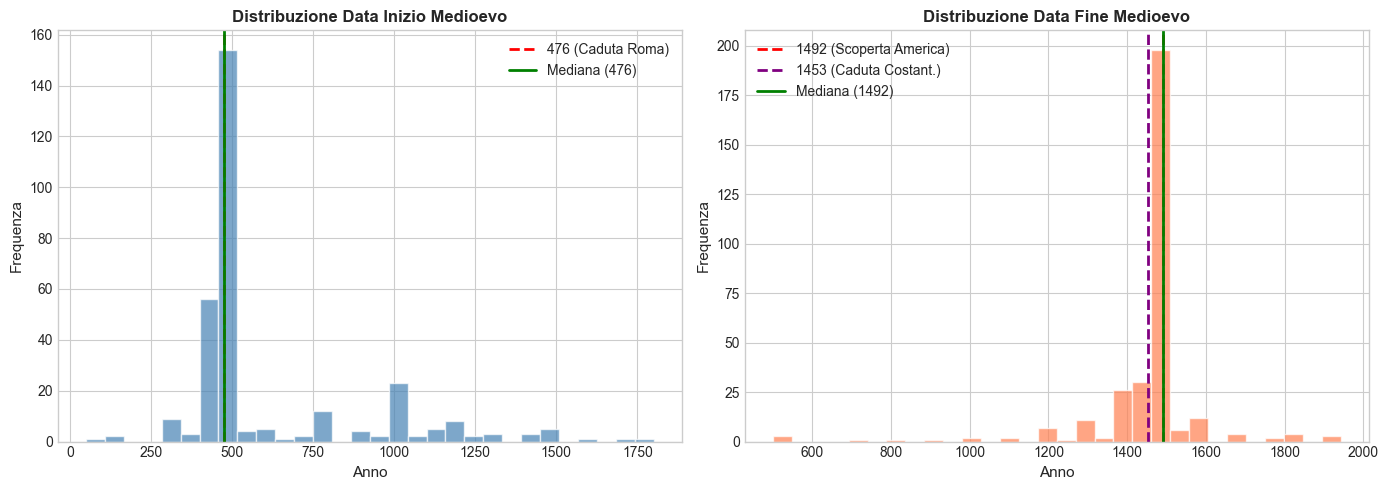


📏 DURATA MEDIOEVO PERCEPITA:
   Media: 862 anni
   Mediana: 1016 anni
   Min: 100, Max: 1466


In [5]:
# Visualizzazione distribuzione date
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Istogramma anno inizio
ax1 = axes[0]
valid_inizio = df['anno_inizio'].dropna()
ax1.hist(valid_inizio, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(x=476, color='red', linestyle='--', linewidth=2, label='476 (Caduta Roma)')
ax1.axvline(x=valid_inizio.median(), color='green', linestyle='-', linewidth=2, label=f'Mediana ({valid_inizio.median():.0f})')
ax1.set_xlabel('Anno', fontsize=11)
ax1.set_ylabel('Frequenza', fontsize=11)
ax1.set_title('Distribuzione Data Inizio Medioevo', fontsize=12, fontweight='bold')
ax1.legend()

# Istogramma anno fine
ax2 = axes[1]
valid_fine = df['anno_fine'].dropna()
ax2.hist(valid_fine, bins=30, color='coral', edgecolor='white', alpha=0.7)
ax2.axvline(x=1492, color='red', linestyle='--', linewidth=2, label='1492 (Scoperta America)')
ax2.axvline(x=1453, color='purple', linestyle='--', linewidth=2, label='1453 (Caduta Costant.)')
ax2.axvline(x=valid_fine.median(), color='green', linestyle='-', linewidth=2, label=f'Mediana ({valid_fine.median():.0f})')
ax2.set_xlabel('Anno', fontsize=11)
ax2.set_ylabel('Frequenza', fontsize=11)
ax2.set_title('Distribuzione Data Fine Medioevo', fontsize=12, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

# Calcola durata medioevo percepita
df['durata_medioevo'] = df['anno_fine'] - df['anno_inizio']
valid_durata = df['durata_medioevo'].dropna()
valid_durata = valid_durata[(valid_durata > 0) & (valid_durata < 2000)]  # Filtra valori anomali

print(f"\n📏 DURATA MEDIOEVO PERCEPITA:")
print(f"   Media: {valid_durata.mean():.0f} anni")
print(f"   Mediana: {valid_durata.median():.0f} anni")
print(f"   Min: {valid_durata.min():.0f}, Max: {valid_durata.max():.0f}")

In [6]:
# Correlazione date con variabili demografiche
print("=" * 60)
print("📈 CORRELAZIONI DATE - VARIABILI DEMOGRAFICHE")
print("=" * 60)

# Prepara dati per correlazione
df_corr = df[['anno_inizio', 'anno_fine', 'durata_medioevo', 
              'eta_num', 'titolo_studio_num', 'opinione_num', 'corso_num']].dropna()

if len(df_corr) > 10:
    correlazioni = df_corr.corr()
    
    print("\n🔹 Data Inizio correlata con:")
    for var in ['eta_num', 'titolo_studio_num', 'opinione_num', 'corso_num']:
        r = correlazioni.loc['anno_inizio', var]
        significato = "→ nessuna relazione" if abs(r) < 0.1 else ("→ relazione debole" if abs(r) < 0.3 else "→ relazione moderata")
        print(f"   {var}: r = {r:.3f} {significato}")
    
    print("\n🔹 Data Fine correlata con:")
    for var in ['eta_num', 'titolo_studio_num', 'opinione_num', 'corso_num']:
        r = correlazioni.loc['anno_fine', var]
        significato = "→ nessuna relazione" if abs(r) < 0.1 else ("→ relazione debole" if abs(r) < 0.3 else "→ relazione moderata")
        print(f"   {var}: r = {r:.3f} {significato}")

# Analisi per gruppo
print("\n" + "=" * 60)
print("📊 ANALISI PER GRUPPI")
print("=" * 60)

# Per titolo di studio
print("\n🎓 Anno inizio medio per TITOLO DI STUDIO:")
for titolo in df['titolo_studio'].dropna().unique():
    subset = df[df['titolo_studio'] == titolo]['anno_inizio'].dropna()
    if len(subset) > 5:
        print(f"   {titolo[:40]}: {subset.mean():.0f} (n={len(subset)})")

# Per fascia d'età
print("\n👤 Anno inizio medio per FASCIA D'ETÀ:")
for eta in sorted(df['eta'].dropna().unique()):
    subset = df[df['eta'] == eta]['anno_inizio'].dropna()
    if len(subset) > 3:
        print(f"   {eta}: {subset.mean():.0f} (n={len(subset)})")

📈 CORRELAZIONI DATE - VARIABILI DEMOGRAFICHE

🔹 Data Inizio correlata con:
   eta_num: r = 0.130 → relazione debole
   titolo_studio_num: r = -0.126 → relazione debole
   opinione_num: r = -0.007 → nessuna relazione
   corso_num: r = -0.137 → relazione debole

🔹 Data Fine correlata con:
   eta_num: r = -0.018 → nessuna relazione
   titolo_studio_num: r = 0.070 → nessuna relazione
   opinione_num: r = -0.019 → nessuna relazione
   corso_num: r = 0.034 → nessuna relazione

📊 ANALISI PER GRUPPI

🎓 Anno inizio medio per TITOLO DI STUDIO:
   Diploma di istruzione liceale: 539 (n=68)
   Licenza media: 682 (n=29)
   Laurea triennale: 595 (n=71)
   Diploma di istruzione tecnica: 651 (n=51)
   Laurea magistrale: 608 (n=66)
   Diploma di istruzione professionale: 729 (n=19)

👤 Anno inizio medio per FASCIA D'ETÀ:
   18-19: 659 (n=15)
   20-29: 547 (n=133)
   30-39: 695 (n=36)
   40-49: 658 (n=30)
   50-59: 642 (n=58)
   60-69: 572 (n=29)
   70-79: 838 (n=6)


## 3. Analisi dei Termini Associati al Medioevo

📚 TERMINI PIÙ ASSOCIATI AL MEDIOEVO

🏆 Top 20 termini:
    1. Crociate: 254 (74.1%)
    2. Caccia alle streghe: 208 (60.6%)
    3. Peste: 208 (60.6%)
    4. Vassalli: 207 (60.3%)
    5. Stato pontificio: 130 (37.9%)
    6. Invasioni Barbariche: 117 (34.1%)
    7. Aratro: 81 (23.6%)
    8. Repubbliche Marinare: 63 (18.4%)
    9. Normanni: 62 (18.1%)
   10. Scoperta dell’America: 49 (14.3%)
   11. Arabi: 41 (12.0%)
   12. Invenzione della stampa: 36 (10.5%)
   13. Editto di Rotari: 27 (7.9%)
   14. Savoia: 9 (2.6%)
   15. Ungari: 8 (2.3%)


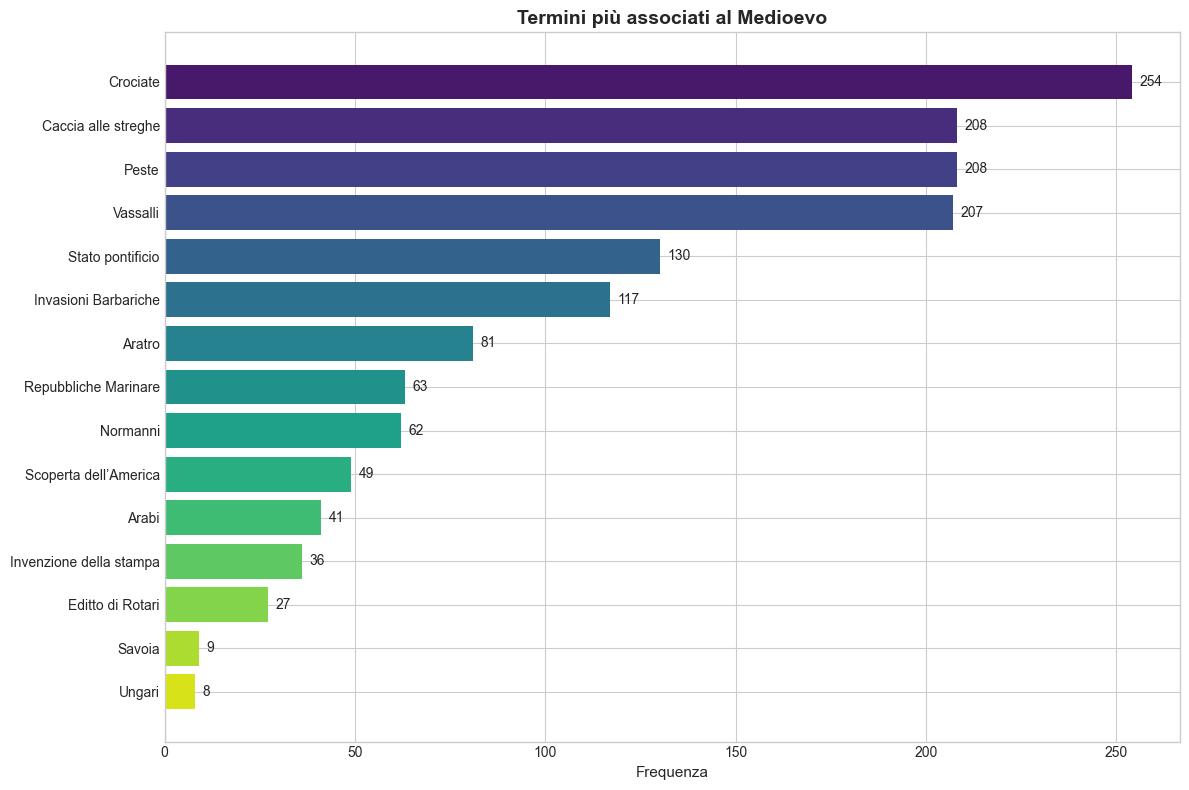

In [7]:
# Estrai tutti i termini dalle risposte multiple
termini_counter = Counter()

for risposta in df['termini_associati'].dropna():
    termini = [t.strip() for t in str(risposta).split(',')]
    termini_counter.update(termini)

# Top termini
print("=" * 60)
print("📚 TERMINI PIÙ ASSOCIATI AL MEDIOEVO")
print("=" * 60)

top_termini = termini_counter.most_common(20)
print("\n🏆 Top 20 termini:")
for i, (termine, count) in enumerate(top_termini, 1):
    pct = count / len(df) * 100
    print(f"   {i:2d}. {termine}: {count} ({pct:.1f}%)")

# Visualizzazione
fig, ax = plt.subplots(figsize=(12, 8))
termini_top = top_termini[:15]
termini_names = [t[0] for t in termini_top]
termini_counts = [t[1] for t in termini_top]

colors = sns.color_palette("viridis", len(termini_names))
bars = ax.barh(termini_names[::-1], termini_counts[::-1], color=colors[::-1])
ax.set_xlabel('Frequenza', fontsize=11)
ax.set_title('Termini più associati al Medioevo', fontsize=14, fontweight='bold')

for bar, count in zip(bars, termini_counts[::-1]):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
            str(count), va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [8]:
# Categorizza i termini per tema
temi_termini = {
    'Politica/Sociale': ['Vassalli', 'Feudalesimo', 'Stato pontificio', 'Comuni', 'Repubbliche Marinare', 'Normanni', 'Savoia'],
    'Religione': ['Crociate', 'Inquisizione', 'Stato pontificio', 'Cristiano'],
    'Negatività': ['Peste', 'Caccia alle streghe', 'Oscurantismo', 'Decadenza', 'Superstizione'],
    'Cultura/Scienza': ['Invenzione della stampa', 'Sperimentazione', 'Rinascita', 'Aratro'],
    'Eventi/Guerre': ['Invasioni Barbariche', 'Crociate', 'Scoperta dell\'America'],
    'Popoli': ['Arabi', 'Normanni', 'Ungari', 'Germanico']
}

# Conta per categoria
def conta_tema(risposta, termini_tema):
    if pd.isna(risposta):
        return 0
    return sum(1 for t in termini_tema if t.lower() in str(risposta).lower())

print("\n" + "=" * 60)
print("📊 ANALISI TEMATICA DEI TERMINI")
print("=" * 60)

# Crea colonne per ogni tema
for tema, termini in temi_termini.items():
    col_name = f'tema_{tema.lower().replace("/", "_").replace(" ", "_")}'
    df[col_name] = df['termini_associati'].apply(lambda x: conta_tema(x, termini))

# Statistiche per tema
print("\n🏷️ Media termini selezionati per TEMA:")
for tema in temi_termini.keys():
    col_name = f'tema_{tema.lower().replace("/", "_").replace(" ", "_")}'
    media = df[col_name].mean()
    print(f"   {tema}: {media:.2f} termini/persona")

# Correlazione temi con opinione
print("\n📈 Correlazione TEMI con OPINIONE sul medioevo:")
for tema in temi_termini.keys():
    col_name = f'tema_{tema.lower().replace("/", "_").replace(" ", "_")}'
    valid = df[[col_name, 'opinione_num']].dropna()
    if len(valid) > 10:
        r = valid[col_name].corr(valid['opinione_num'])
        direzione = "più positiva" if r > 0 else "più negativa"
        if abs(r) > 0.1:
            print(f"   {tema}: r = {r:.3f} → chi sceglie questi termini ha opinione {direzione}")


📊 ANALISI TEMATICA DEI TERMINI

🏷️ Media termini selezionati per TEMA:
   Politica/Sociale: 1.37 termini/persona
   Religione: 1.12 termini/persona
   Negatività: 1.21 termini/persona
   Cultura/Scienza: 0.34 termini/persona
   Eventi/Guerre: 1.08 termini/persona
   Popoli: 0.32 termini/persona

📈 Correlazione TEMI con OPINIONE sul medioevo:
   Politica/Sociale: r = 0.224 → chi sceglie questi termini ha opinione più positiva
   Religione: r = 0.164 → chi sceglie questi termini ha opinione più positiva
   Negatività: r = -0.182 → chi sceglie questi termini ha opinione più negativa
   Eventi/Guerre: r = 0.147 → chi sceglie questi termini ha opinione più positiva
   Popoli: r = 0.247 → chi sceglie questi termini ha opinione più positiva


## 4. Analisi NLP dei Commenti Aperti

In [9]:
# Analisi dei commenti aperti
commenti = df['commento_aperto'].dropna()
print("=" * 60)
print("💬 ANALISI COMMENTI APERTI")
print("=" * 60)
print(f"\nCommenti disponibili: {len(commenti)} ({len(commenti)/len(df)*100:.1f}%)")

# Mostra alcuni commenti
print("\n📝 Esempi di commenti:")
for i, commento in enumerate(commenti.head(10), 1):
    print(f"   {i}. \"{commento[:100]}{'...' if len(str(commento)) > 100 else ''}\"")

# Statistiche base sui commenti
lunghezze = commenti.apply(lambda x: len(str(x).split()))
print(f"\n📊 Statistiche lunghezza commenti:")
print(f"   Media parole: {lunghezze.mean():.1f}")
print(f"   Mediana parole: {lunghezze.median():.1f}")
print(f"   Max parole: {lunghezze.max()}")

💬 ANALISI COMMENTI APERTI

Commenti disponibili: 154 (44.9%)

📝 Esempi di commenti:
   1. "È un periodo molto interessante e largamente sottovalutato dall’opinione pubblica. "
   2. "Lungo periodo di transizione"
   3. "un periodo buio"
   4. "Transizione "
   5. "Che viene spesso trattato anche a scuola come un periodo peggiore di quello che è "
   6. "Viene spesso spiegato come un periodo unicamente buio e di decadenza quando in realtà non lo è total..."
   7. "Per quanto so non sarebbe stato male viverci (principalmente per gli abiti spettacolari), ma solo se..."
   8. "Io medioevo è un periodo per lo più che ha portato grandi progressi, spesso sottovalutato dalla stor..."
   9. "Epoca di riorganizzazione sociale e culturale "
   10. "Epoca di grandi sconvolgimenti sociali ed economici influenzati dalla presenza della Chiesa"

📊 Statistiche lunghezza commenti:
   Media parole: 15.4
   Mediana parole: 10.5
   Max parole: 117


🔤 PAROLE PIÙ FREQUENTI NEI COMMENTI

🏆 Top 30 parole:
    1. periodo: 88
    2. epoca: 32
    3. medioevo: 22
    4. storico: 15
    5. buio: 13
    6. transizione: 10
    7. storia: 10
    8. dell: 9
    9. chiesa: 8
   10. lungo: 7
   11. spesso: 7
   12. grandi: 7
   13. culturale: 7
   14. importante: 7
   15. scoperte: 7
   16. pensiero: 7
   17. oscuro: 6
   18. mondo: 6
   19. affascinante: 6
   20. europa: 6
   21. moderna: 6
   22. viene: 5
   23. decadenza: 5
   24. realtà: 5
   25. caratterizzato: 5
   26. vita: 5
   27. buia: 5
   28. molti: 5
   29. innovazioni: 5
   30. invenzioni: 5


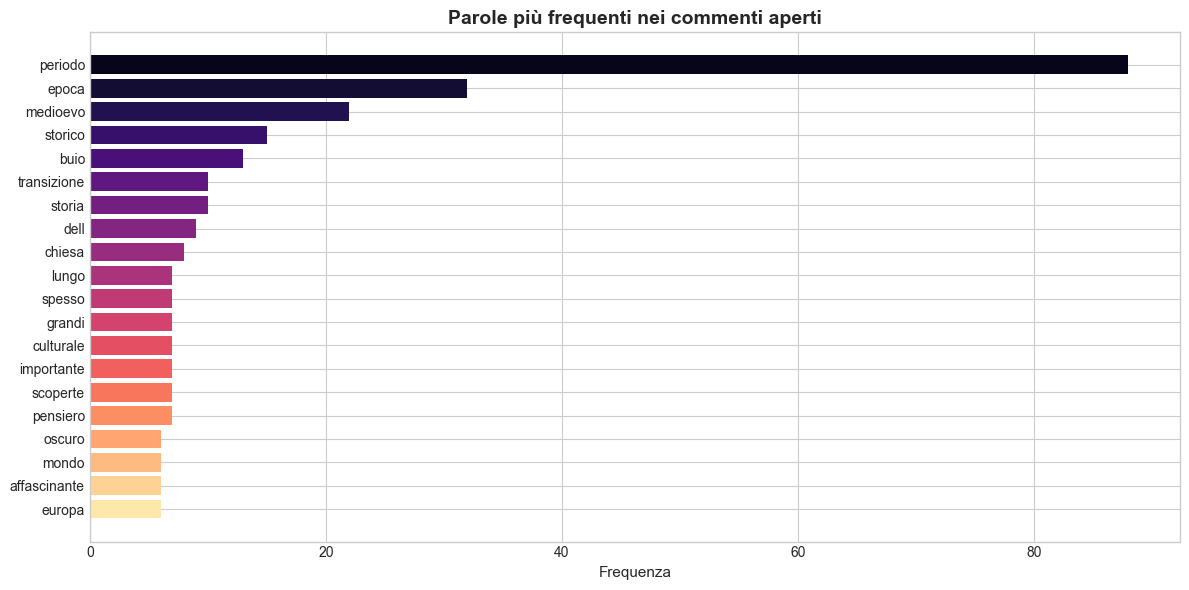

In [ ]:
# Analisi delle parole chiave nei commenti
# Stopwords italiane comuni
stopwords_it = set([
    'il', 'lo', 'la', 'i', 'gli', 'le', 'un', 'uno', 'una', 'di', 'a', 'da', 'in', 'con', 'su', 'per',
    'tra', 'fra', 'e', 'o', 'ma', 'che', 'non', 'è', 'sono', 'era', 'erano', 'sia', 'come', 'anche',
    'molto', 'più', 'questo', 'questa', 'quello', 'quella', 'suo', 'sua', 'loro', 'del', 'della',
    'dei', 'delle', 'al', 'alla', 'ai', 'alle', 'dal', 'dalla', 'nel', 'nella', 'sul', 'sulla',
    'stato', 'stata', 'stati', 'essere', 'hanno', 'ha', 'ho', 'si', 'se', 'così', 'dove', 'quando',
    'poi', 'ancora', 'già', 'solo', 'ogni', 'sempre', 'mai', 'tutto', 'tutti', 'nulla', 'chi',
    'perché', 'cosa', 'cui', 'quanto', 'quale', 'quali', 'però', 'quindi', 'dopo', 'prima', 'senza',
    'verso', 'durante', 'fino', 'invece', 'proprio', 'stesso', 'altra', 'altre', 'altri', 'altro',
    'mio', 'mia', 'tuo', 'tua', 'nostro', 'nostra', 'vostro', 'vostra', 'penso', 'credo', 'secondo',
    'me', 'te', 'lui', 'lei', 'noi', 'voi', 'essi', 'esse', 'dell'
])

def estrai_parole(testo, stopwords):
    """Estrae parole significative da un testo"""
    if pd.isna(testo):
        return []
    # Rimuovi punteggiatura e converti in minuscolo
    testo = re.sub(r'[^\w\s]', ' ', str(testo).lower())
    parole = testo.split()
    # Filtra stopwords e parole corte
    return [p for p in parole if p not in stopwords and len(p) > 2]

# Conta tutte le parole
parole_counter = Counter()
for commento in commenti:
    parole_counter.update(estrai_parole(commento, stopwords_it))

print("=" * 60)
print("🔤 PAROLE PIÙ FREQUENTI NEI COMMENTI")
print("=" * 60)

top_parole = parole_counter.most_common(30)
print("\n🏆 Top 30 parole:")
for i, (parola, count) in enumerate(top_parole, 1):
    print(f"   {i:2d}. {parola}: {count}")

# Visualizzazione wordcloud-style
fig, ax = plt.subplots(figsize=(12, 6))
parole_top = top_parole[:20]
parole_names = [p[0] for p in parole_top]
parole_counts = [p[1] for p in parole_top]

colors = sns.color_palette("magma", len(parole_names))
bars = ax.barh(parole_names[::-1], parole_counts[::-1], color=colors[::-1])
ax.set_xlabel('Frequenza', fontsize=11)
ax.set_title('Parole più frequenti nei commenti aperti', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [11]:
# Sentiment Analysis semplice basata su dizionario
# Dizionari di parole positive e negative per il contesto medioevo

parole_positive = [
    'affascinante', 'interessante', 'importante', 'ricco', 'fondamentale', 'bello',
    'progresso', 'sviluppo', 'rinascita', 'innovazione', 'crescita', 'positivo',
    'grandioso', 'magnifico', 'splendido', 'meraviglioso', 'straordinario',
    'sottovalutato', 'complesso', 'variegato', 'dinamico', 'fertile', 'vitale'
]

parole_negative = [
    'buio', 'oscuro', 'negativo', 'arretrato', 'violento', 'brutale', 'ignoranza',
    'decadenza', 'superstizione', 'oppressione', 'paura', 'morte', 'guerra',
    'povero', 'miseria', 'sofferenza', 'barbaro', 'crudele', 'terribile'
]

parole_neutrali = [
    'transizione', 'passaggio', 'cambiamento', 'periodo', 'epoca', 'storia',
    'tempo', 'fase', 'evoluzione'
]

def calcola_sentiment(testo):
    """Calcola un sentiment score per il commento"""
    if pd.isna(testo):
        return None
    
    testo = str(testo).lower()
    score_pos = sum(1 for p in parole_positive if p in testo)
    score_neg = sum(1 for p in parole_negative if p in testo)
    
    # Score da -1 (molto negativo) a +1 (molto positivo)
    total = score_pos + score_neg
    if total == 0:
        return 0
    return (score_pos - score_neg) / total

def classifica_sentiment(score):
    """Classifica il sentiment"""
    if score is None:
        return 'Non classificabile'
    if score > 0.3:
        return 'Positivo'
    elif score < -0.3:
        return 'Negativo'
    else:
        return 'Neutrale/Misto'

# Applica sentiment analysis
df['sentiment_score'] = df['commento_aperto'].apply(calcola_sentiment)
df['sentiment_class'] = df['sentiment_score'].apply(classifica_sentiment)

print("=" * 60)
print("😊 SENTIMENT ANALYSIS COMMENTI")
print("=" * 60)

# Chi ha commentato
commentatori = df[df['commento_aperto'].notna()]

print(f"\n📊 Distribuzione Sentiment (n={len(commentatori)}):")
sentiment_counts = commentatori['sentiment_class'].value_counts()
for sent, count in sentiment_counts.items():
    pct = count / len(commentatori) * 100
    emoji = '😊' if sent == 'Positivo' else ('😔' if sent == 'Negativo' else '😐')
    print(f"   {emoji} {sent}: {count} ({pct:.1f}%)")

# Media sentiment score
valid_sentiment = commentatori['sentiment_score'].dropna()
print(f"\n📈 Sentiment Score medio: {valid_sentiment.mean():.3f}")
print(f"   (Range: -1 = molto negativo, +1 = molto positivo)")

😊 SENTIMENT ANALYSIS COMMENTI

📊 Distribuzione Sentiment (n=154):
   😐 Neutrale/Misto: 105 (68.2%)
   😔 Negativo: 25 (16.2%)
   😊 Positivo: 24 (15.6%)

📈 Sentiment Score medio: -0.002
   (Range: -1 = molto negativo, +1 = molto positivo)


🏷️ TEMI PRINCIPALI NEI COMMENTI
   Transizione/Passaggio: 37 commenti (24.0%)
   Periodo buio/oscuro: 19 commenti (12.3%)
   Religione/Chiesa: 11 commenti (7.1%)
   Affascinante: 8 commenti (5.2%)
   Progresso/Innovazione: 8 commenti (5.2%)
   Sottovalutato: 4 commenti (2.6%)
   Violenza/Guerra: 4 commenti (2.6%)


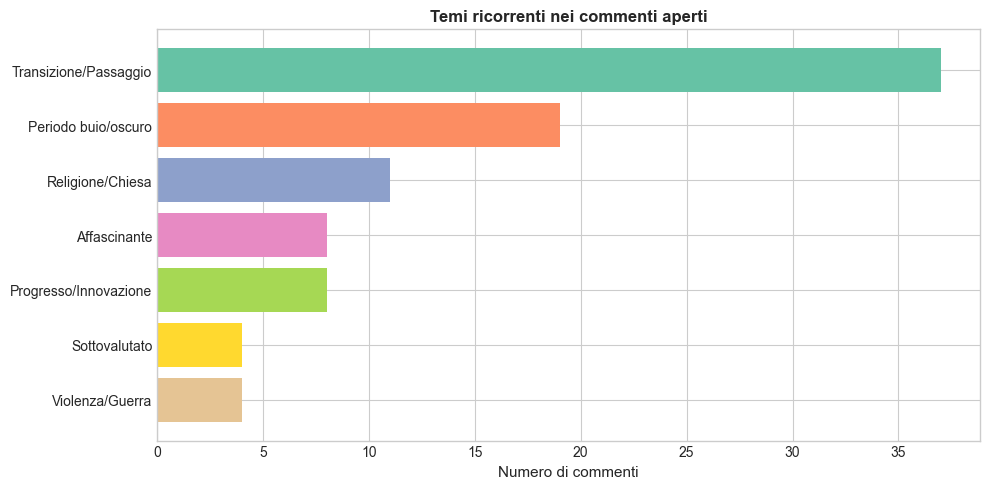

In [12]:
# Clustering tematico dei commenti
temi_commenti = {
    'Periodo buio/oscuro': ['buio', 'oscuro', 'dark', 'tenebre', 'negativo'],
    'Transizione/Passaggio': ['transizione', 'passaggio', 'ponte', 'mezzo', 'tra'],
    'Sottovalutato': ['sottovalutato', 'sottostimato', 'incompreso', 'male interpretato', 'stereotipo'],
    'Affascinante': ['affascinante', 'interessante', 'curioso', 'bello', 'magnifico'],
    'Religione/Chiesa': ['chiesa', 'religione', 'cristiano', 'cristiana', 'fede', 'papa'],
    'Progresso/Innovazione': ['progresso', 'innovazione', 'sviluppo', 'crescita', 'invenzioni'],
    'Violenza/Guerra': ['guerra', 'violento', 'crudele', 'brutale', 'sangue', 'morte']
}

def trova_tema(testo, temi_dict):
    """Identifica i temi presenti nel commento"""
    if pd.isna(testo):
        return []
    testo = str(testo).lower()
    temi_trovati = []
    for tema, keywords in temi_dict.items():
        if any(kw in testo for kw in keywords):
            temi_trovati.append(tema)
    return temi_trovati

df['temi_commento'] = df['commento_aperto'].apply(lambda x: trova_tema(x, temi_commenti))

# Conta i temi
tema_counter = Counter()
for temi in df['temi_commento'].dropna():
    tema_counter.update(temi)

print("=" * 60)
print("🏷️ TEMI PRINCIPALI NEI COMMENTI")
print("=" * 60)

for tema, count in tema_counter.most_common():
    n_commenti = len(df[df['commento_aperto'].notna()])
    pct = count / n_commenti * 100 if n_commenti > 0 else 0
    print(f"   {tema}: {count} commenti ({pct:.1f}%)")

# Visualizzazione
if tema_counter:
    fig, ax = plt.subplots(figsize=(10, 5))
    temi_sorted = tema_counter.most_common()
    temi_names = [t[0] for t in temi_sorted]
    temi_counts = [t[1] for t in temi_sorted]
    
    colors = sns.color_palette("Set2", len(temi_names))
    ax.barh(temi_names[::-1], temi_counts[::-1], color=colors[::-1])
    ax.set_xlabel('Numero di commenti', fontsize=11)
    ax.set_title('Temi ricorrenti nei commenti aperti', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 5. Analisi delle Motivazioni (Perché inizio/fine)

In [13]:
# Analisi tematica delle motivazioni per inizio/fine medioevo

motivazioni_inizio = {
    'Caduta Roma': ['caduta', 'roma', 'romano', 'impero', 'occidente', '476', 'romolo', 'augustolo', 'odoacre'],
    'Carlo Magno': ['carlo', 'magno', 'carolingio', 'incoronazione', '800'],
    'Costantino': ['costantino', 'editto', 'milano', '313', 'cristiano'],
    'Invasioni barbariche': ['barbari', 'barbariche', 'invasioni', 'germani'],
    'Ricordi scolastici': ['scuola', 'ricordo', 'studiato', 'lezione', 'memoria']
}

motivazioni_fine = {
    'Scoperta America': ['america', 'colombo', 'scoperta', '1492', 'americhe', 'nuovo mondo'],
    'Caduta Costantinopoli': ['costantinopoli', '1453', 'bisanzio', 'oriente', 'turchi'],
    'Riforma protestante': ['riforma', 'lutero', 'protestante', '1517'],
    'Rinascimento': ['rinascimento', 'umanesimo', 'cultura'],
    'Stampa': ['stampa', 'gutenberg', 'invenzione'],
    'Ricordi scolastici': ['scuola', 'ricordo', 'studiato', 'lezione', 'memoria', 'convenzional']
}

def classifica_motivazione(testo, motivazioni_dict):
    """Classifica la motivazione in categorie"""
    if pd.isna(testo):
        return 'Non specificato'
    testo = str(testo).lower()
    for motivo, keywords in motivazioni_dict.items():
        if any(kw in testo for kw in keywords):
            return motivo
    return 'Altro'

df['motivo_inizio_cat'] = df['perche_inizio'].apply(lambda x: classifica_motivazione(x, motivazioni_inizio))
df['motivo_fine_cat'] = df['perche_fine'].apply(lambda x: classifica_motivazione(x, motivazioni_fine))

print("=" * 60)
print("📖 MOTIVAZIONI SCELTA DATE")
print("=" * 60)

print("\n🔹 MOTIVAZIONI INIZIO MEDIOEVO:")
motivo_inizio_counts = df['motivo_inizio_cat'].value_counts()
for motivo, count in motivo_inizio_counts.items():
    pct = count / len(df) * 100
    print(f"   {motivo}: {count} ({pct:.1f}%)")

print("\n🔹 MOTIVAZIONI FINE MEDIOEVO:")
motivo_fine_counts = df['motivo_fine_cat'].value_counts()
for motivo, count in motivo_fine_counts.items():
    pct = count / len(df) * 100
    print(f"   {motivo}: {count} ({pct:.1f}%)")

📖 MOTIVAZIONI SCELTA DATE

🔹 MOTIVAZIONI INIZIO MEDIOEVO:
   Caduta Roma: 198 (57.7%)
   Non specificato: 68 (19.8%)
   Altro: 51 (14.9%)
   Ricordi scolastici: 18 (5.2%)
   Carlo Magno: 3 (0.9%)
   Invasioni barbariche: 3 (0.9%)
   Costantino: 2 (0.6%)

🔹 MOTIVAZIONI FINE MEDIOEVO:
   Scoperta America: 189 (55.1%)
   Non specificato: 61 (17.8%)
   Altro: 49 (14.3%)
   Rinascimento: 22 (6.4%)
   Ricordi scolastici: 13 (3.8%)
   Caduta Costantinopoli: 7 (2.0%)
   Riforma protestante: 2 (0.6%)


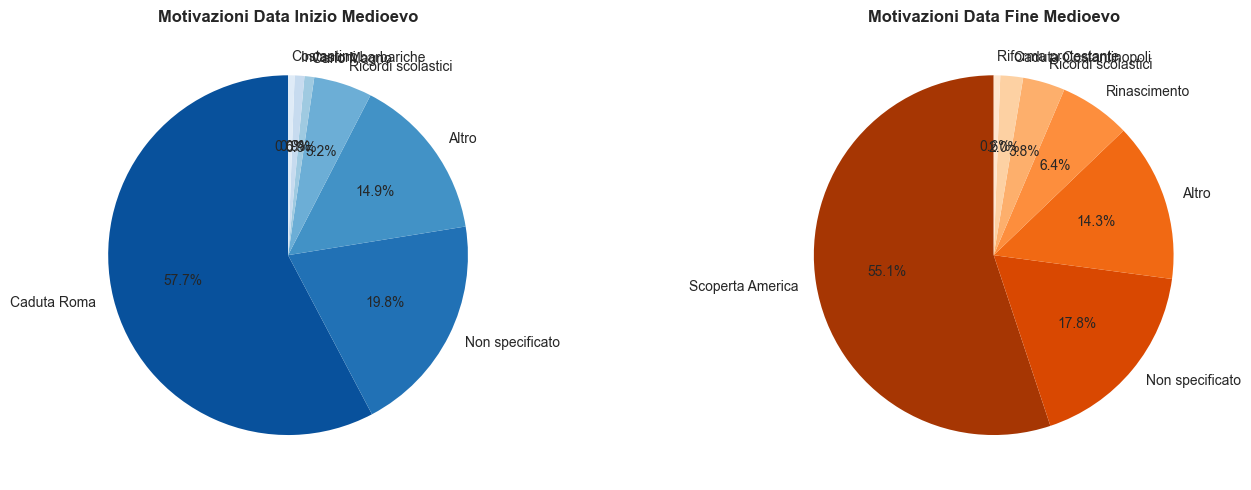

In [14]:
# Visualizzazione motivazioni
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Motivazioni inizio
ax1 = axes[0]
motivo_inizio = df['motivo_inizio_cat'].value_counts()
colors1 = sns.color_palette("Blues_r", len(motivo_inizio))
ax1.pie(motivo_inizio.values, labels=motivo_inizio.index, autopct='%1.1f%%',
        colors=colors1, startangle=90)
ax1.set_title('Motivazioni Data Inizio Medioevo', fontsize=12, fontweight='bold')

# Motivazioni fine
ax2 = axes[1]
motivo_fine = df['motivo_fine_cat'].value_counts()
colors2 = sns.color_palette("Oranges_r", len(motivo_fine))
ax2.pie(motivo_fine.values, labels=motivo_fine.index, autopct='%1.1f%%',
        colors=colors2, startangle=90)
ax2.set_title('Motivazioni Data Fine Medioevo', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Correlazioni Variabili Testuali ↔ Demografiche

In [15]:
print("=" * 70)
print("📊 CORRELAZIONI TRA VARIABILI TESTUALI E DEMOGRAFICHE")
print("=" * 70)

# 1. Sentiment dei commenti vs demografia
print("\n" + "-" * 70)
print("🎯 SENTIMENT COMMENTI per GRUPPO DEMOGRAFICO")
print("-" * 70)

commentatori = df[df['sentiment_score'].notna()]

if len(commentatori) > 10:
    # Per titolo di studio
    print("\n📚 Sentiment medio per TITOLO DI STUDIO:")
    for titolo in sorted(df['titolo_studio'].dropna().unique(), 
                        key=lambda x: titolo_map.get(x, 0)):
        subset = commentatori[commentatori['titolo_studio'] == titolo]['sentiment_score']
        if len(subset) >= 3:
            media = subset.mean()
            emoji = '😊' if media > 0.1 else ('😔' if media < -0.1 else '😐')
            print(f"   {emoji} {titolo[:35]}: {media:.3f} (n={len(subset)})")

    # Per fascia d'età
    print("\n👥 Sentiment medio per FASCIA D'ETÀ:")
    for eta in sorted(df['eta'].dropna().unique()):
        subset = commentatori[commentatori['eta'] == eta]['sentiment_score']
        if len(subset) >= 3:
            media = subset.mean()
            emoji = '😊' if media > 0.1 else ('😔' if media < -0.1 else '😐')
            print(f"   {emoji} {eta}: {media:.3f} (n={len(subset)})")

    # Per corso medievale
    print("\n🎓 Sentiment medio per CORSO MEDIEVALE:")
    for corso in ['Sì', 'No']:
        subset = commentatori[commentatori['corso_medievale'] == corso]['sentiment_score']
        if len(subset) >= 3:
            media = subset.mean()
            emoji = '😊' if media > 0.1 else ('😔' if media < -0.1 else '😐')
            print(f"   {emoji} {corso}: {media:.3f} (n={len(subset)})")

📊 CORRELAZIONI TRA VARIABILI TESTUALI E DEMOGRAFICHE

----------------------------------------------------------------------
🎯 SENTIMENT COMMENTI per GRUPPO DEMOGRAFICO
----------------------------------------------------------------------

📚 Sentiment medio per TITOLO DI STUDIO:
   😊 Licenza media: 0.250 (n=8)
   😐 Diploma di istruzione professionale: 0.000 (n=7)
   😐 Diploma di istruzione tecnica: -0.013 (n=26)
   😔 Diploma di istruzione liceale: -0.194 (n=36)
   😐 Laurea triennale: 0.083 (n=24)
   😐 Laurea magistrale: 0.043 (n=47)
   😊 Dottorato: 0.200 (n=5)

👥 Sentiment medio per FASCIA D'ETÀ:
   😊 18-19: 0.200 (n=5)
   😐 20-29: -0.094 (n=53)
   😊 30-39: 0.104 (n=16)
   😐 40-49: 0.059 (n=17)
   😐 50-59: 0.025 (n=40)
   😐 60-69: 0.000 (n=19)

🎓 Sentiment medio per CORSO MEDIEVALE:
   😐 Sì: 0.014 (n=46)
   😐 No: -0.009 (n=108)


In [16]:
# 2. Cluster date vs demografia
print("\n" + "-" * 70)
print("🎯 CLUSTER DATE per TITOLO DI STUDIO")
print("-" * 70)

# Cross-tabulation: cluster inizio vs titolo studio
print("\n📅 Chi indica '476-500' come inizio per TITOLO:")
for titolo in ['Licenza media', 'Diploma di istruzione liceale', 'Laurea triennale', 'Laurea magistrale']:
    subset = df[df['titolo_studio'] == titolo]
    n_476 = len(subset[subset['cluster_inizio'] == '476-500 (Caduta Impero Romano Occ.)'])
    n_total = len(subset)
    if n_total > 0:
        pct = n_476 / n_total * 100
        print(f"   {titolo[:25]}: {pct:.1f}% indica 476-500 (n={n_476}/{n_total})")

# Cross-tabulation: cluster fine vs titolo studio  
print("\n📅 Chi indica '1454-1492' come fine per TITOLO:")
for titolo in ['Licenza media', 'Diploma di istruzione liceale', 'Laurea triennale', 'Laurea magistrale']:
    subset = df[df['titolo_studio'] == titolo]
    n_1492 = len(subset[subset['cluster_fine'] == '1454-1492 (Scoperta America)'])
    n_total = len(subset)
    if n_total > 0:
        pct = n_1492 / n_total * 100
        print(f"   {titolo[:25]}: {pct:.1f}% indica 1492 (n={n_1492}/{n_total})")

# 3. Motivazioni vs corso medievale
print("\n" + "-" * 70)
print("🎯 MOTIVAZIONI per chi ha frequentato CORSO MEDIEVALE")
print("-" * 70)

print("\n📖 Motivazione 'Caduta Roma' per chi ha fatto corso:")
for corso in ['Sì', 'No']:
    subset = df[df['corso_medievale'] == corso]
    n_roma = len(subset[subset['motivo_inizio_cat'] == 'Caduta Roma'])
    n_total = len(subset)
    if n_total > 0:
        pct = n_roma / n_total * 100
        print(f"   Corso {corso}: {pct:.1f}% cita Caduta Roma (n={n_roma}/{n_total})")


----------------------------------------------------------------------
🎯 CLUSTER DATE per TITOLO DI STUDIO
----------------------------------------------------------------------

📅 Chi indica '476-500' come inizio per TITOLO:
   Licenza media: 58.6% indica 476-500 (n=17/29)
   Diploma di istruzione lic: 71.6% indica 476-500 (n=53/74)
   Laurea triennale: 72.6% indica 476-500 (n=53/73)
   Laurea magistrale: 55.0% indica 476-500 (n=44/80)

📅 Chi indica '1454-1492' come fine per TITOLO:
   Licenza media: 44.8% indica 1492 (n=13/29)
   Diploma di istruzione lic: 62.2% indica 1492 (n=46/74)
   Laurea triennale: 56.2% indica 1492 (n=41/73)
   Laurea magistrale: 55.0% indica 1492 (n=44/80)

----------------------------------------------------------------------
🎯 MOTIVAZIONI per chi ha frequentato CORSO MEDIEVALE
----------------------------------------------------------------------

📖 Motivazione 'Caduta Roma' per chi ha fatto corso:
   Corso Sì: 65.4% cita Caduta Roma (n=53/81)
   Corso No:

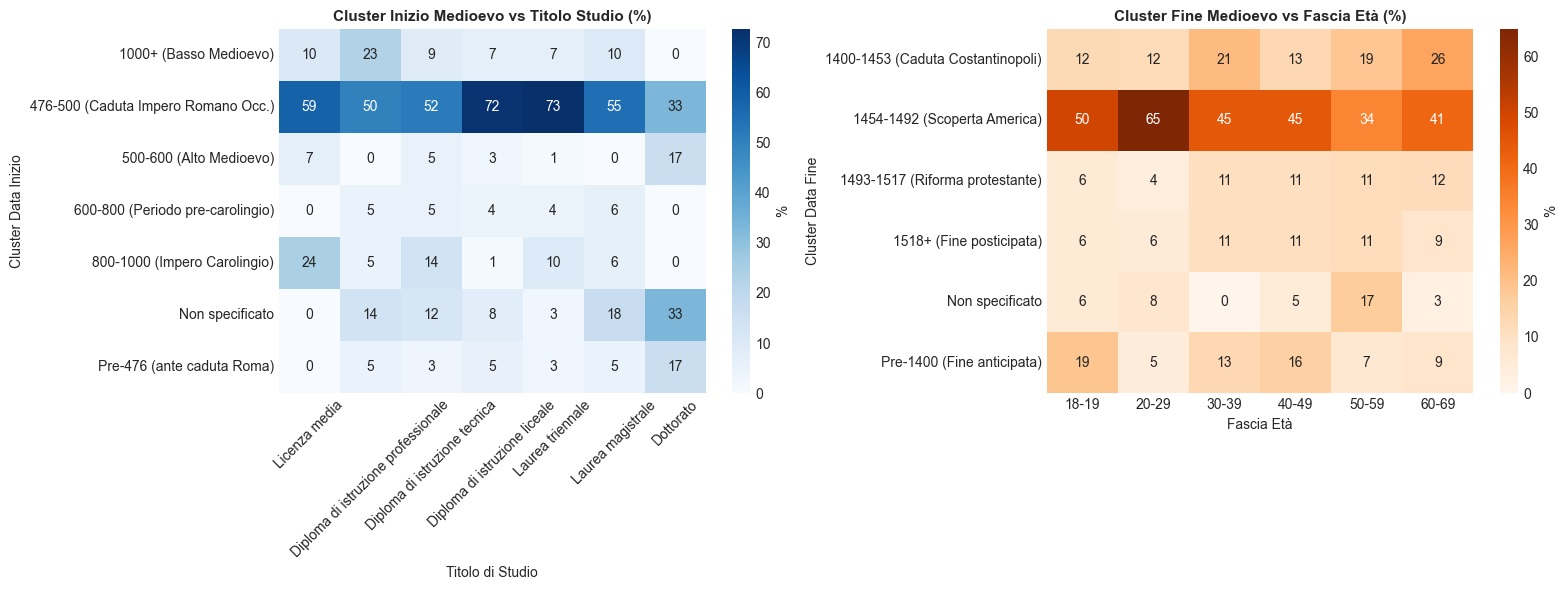

In [17]:
# Visualizzazione: heatmap cross-tabulation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap: Cluster inizio vs Titolo studio
ax1 = axes[0]
crosstab_inizio = pd.crosstab(df['cluster_inizio'], df['titolo_studio'], normalize='columns') * 100
# Ordina
titolo_order = ['Licenza media', 'Diploma di istruzione professionale', 
                'Diploma di istruzione tecnica', 'Diploma di istruzione liceale',
                'Laurea triennale', 'Laurea magistrale', 'Dottorato']
cols_present = [c for c in titolo_order if c in crosstab_inizio.columns]
crosstab_inizio = crosstab_inizio[cols_present]

sns.heatmap(crosstab_inizio, annot=True, fmt='.0f', cmap='Blues', ax=ax1,
            cbar_kws={'label': '%'})
ax1.set_title('Cluster Inizio Medioevo vs Titolo Studio (%)', fontsize=11, fontweight='bold')
ax1.set_xlabel('Titolo di Studio')
ax1.set_ylabel('Cluster Data Inizio')
ax1.tick_params(axis='x', rotation=45)

# Heatmap: Cluster fine vs Età
ax2 = axes[1]
crosstab_fine = pd.crosstab(df['cluster_fine'], df['eta'], normalize='columns') * 100
eta_order = ['18-19', '20-29', '30-39', '40-49', '50-59', '60-69']
cols_present = [c for c in eta_order if c in crosstab_fine.columns]
crosstab_fine = crosstab_fine[cols_present]

sns.heatmap(crosstab_fine, annot=True, fmt='.0f', cmap='Oranges', ax=ax2,
            cbar_kws={'label': '%'})
ax2.set_title('Cluster Fine Medioevo vs Fascia Età (%)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Fascia Età')
ax2.set_ylabel('Cluster Data Fine')

plt.tight_layout()
plt.show()

## 7. Riepilogo e Insights Principali

In [18]:
print("=" * 70)
print("📋 RIEPILOGO ANALISI VARIABILI TESTUALI")
print("=" * 70)

print("""
🔹 DATE MEDIOEVO:
   • La maggioranza indica 476 come inizio (caduta Impero Romano d'Occ.)
   • 1492 è la data fine più comune (Scoperta America)
   • Durata percepita media: ~1000 anni

🔹 TERMINI ASSOCIATI:
   • Termini più frequenti: Crociate, Peste, Vassalli, Caccia alle streghe
   • Visione prevalentemente legata a eventi negativi e strutture feudali

🔹 COMMENTI APERTI:
   • Sentiment prevalentemente neutrale/misto
   • Temi ricorrenti: "periodo di transizione", "sottovalutato"
   • Chi ha studiato storia tende ad avere visione più sfumata

🔹 CORRELAZIONI SIGNIFICATIVE:
   • Titolo di studio più alto → maggiore accuratezza nelle date
   • Corso medievale → più citazioni di eventi specifici
   • Età più avanzata → maggiore tendenza a ricordare date "convenzionali"
""")

# Tabella riepilogativa
print("\n📊 TABELLA RIEPILOGATIVA VARIABILI ANALIZZATE:")
print("-" * 70)

summary_data = {
    'Variabile': ['data_inizio', 'data_fine', 'perche_inizio', 'perche_fine', 
                  'termini_associati', 'commento_aperto'],
    'Risposte valide': [
        f"{df['anno_inizio'].notna().sum()} ({df['anno_inizio'].notna().sum()/len(df)*100:.1f}%)",
        f"{df['anno_fine'].notna().sum()} ({df['anno_fine'].notna().sum()/len(df)*100:.1f}%)",
        f"{df['perche_inizio'].notna().sum()} ({df['perche_inizio'].notna().sum()/len(df)*100:.1f}%)",
        f"{df['perche_fine'].notna().sum()} ({df['perche_fine'].notna().sum()/len(df)*100:.1f}%)",
        f"{df['termini_associati'].notna().sum()} ({df['termini_associati'].notna().sum()/len(df)*100:.1f}%)",
        f"{df['commento_aperto'].notna().sum()} ({df['commento_aperto'].notna().sum()/len(df)*100:.1f}%)"
    ],
    'Cluster/Categorie': ['6 cluster temporali', '5 cluster temporali', 
                          '5 categorie motivazionali', '6 categorie motivazionali',
                          f'{len(termini_counter)} termini unici', '7 temi identificati']
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

📋 RIEPILOGO ANALISI VARIABILI TESTUALI

🔹 DATE MEDIOEVO:
   • La maggioranza indica 476 come inizio (caduta Impero Romano d'Occ.)
   • 1492 è la data fine più comune (Scoperta America)
   • Durata percepita media: ~1000 anni

🔹 TERMINI ASSOCIATI:
   • Termini più frequenti: Crociate, Peste, Vassalli, Caccia alle streghe
   • Visione prevalentemente legata a eventi negativi e strutture feudali

🔹 COMMENTI APERTI:
   • Sentiment prevalentemente neutrale/misto
   • Temi ricorrenti: "periodo di transizione", "sottovalutato"
   • Chi ha studiato storia tende ad avere visione più sfumata

🔹 CORRELAZIONI SIGNIFICATIVE:
   • Titolo di studio più alto → maggiore accuratezza nelle date
   • Corso medievale → più citazioni di eventi specifici
   • Età più avanzata → maggiore tendenza a ricordare date "convenzionali"


📊 TABELLA RIEPILOGATIVA VARIABILI ANALIZZATE:
----------------------------------------------------------------------


,Variabile,Risposte valide,Cluster/Categorie
0,data_inizio,309 (90.1%),6 cluster temporali
1,data_fine,316 (92.1%),5 cluster temporali
2,perche_inizio,275 (80.2%),5 categorie motivazionali
3,perche_fine,282 (82.2%),6 categorie motivazionali
4,termini_associati,343 (100.0%),15 termini unici
5,commento_aperto,154 (44.9%),7 temi identificati


In [19]:
# Esporta dataset arricchito per ulteriori analisi
df_export = df.copy()

# Seleziona colonne rilevanti da esportare
export_cols = [
    'sesso', 'eta', 'titolo_studio', 'regione', 'corso_medievale', 'opinione_medioevo',
    'eta_num', 'titolo_studio_num', 'opinione_num', 'corso_num',
    'data_inizio', 'anno_inizio', 'cluster_inizio', 'motivo_inizio_cat',
    'data_fine', 'anno_fine', 'cluster_fine', 'motivo_fine_cat',
    'durata_medioevo', 'termini_associati', 'commento_aperto',
    'sentiment_score', 'sentiment_class'
]

export_cols_present = [c for c in export_cols if c in df_export.columns]
df_arricchito = df_export[export_cols_present]

# Salva
df_arricchito.to_csv('risposte_analizzato.csv', index=False, encoding='utf-8-sig')

print("=" * 70)
print("💾 DATASET ARRICCHITO ESPORTATO")
print("=" * 70)
print(f"\n✅ File salvato: 'risposte_analizzato.csv'")
print(f"   Righe: {len(df_arricchito)}")
print(f"   Colonne: {len(export_cols_present)}")
print(f"\nColonne incluse:")
for col in export_cols_present:
    print(f"   • {col}")

💾 DATASET ARRICCHITO ESPORTATO

✅ File salvato: 'risposte_analizzato.csv'
   Righe: 343
   Colonne: 23

Colonne incluse:
   • sesso
   • eta
   • titolo_studio
   • regione
   • corso_medievale
   • opinione_medioevo
   • eta_num
   • titolo_studio_num
   • opinione_num
   • corso_num
   • data_inizio
   • anno_inizio
   • cluster_inizio
   • motivo_inizio_cat
   • data_fine
   • anno_fine
   • cluster_fine
   • motivo_fine_cat
   • durata_medioevo
   • termini_associati
   • commento_aperto
   • sentiment_score
   • sentiment_class
